In [27]:
import sys
from pathlib import Path
from os import getcwd
sys.path.append(str(Path(getcwd()).parent))

from datetime import date, timedelta
import codecs
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', None)

from os.path import join

from bulletin import root,default_input, default_output
from bulletin.services.metabase import Metabase
from bulletin.systems.casos_confirmados import CasosConfirmados
from bulletin.systems.notifica import Notifica
from bulletin.utils.static import Municipios
from bulletin.utils.normalize import normalize_hash, normalize_labels, normalize_text, date_hash, normalize_number, normalize_cns, normalize_cpf, normalize_campo_aberto
from bulletin.utils import static
from bulletin.utils.xls_ import fit_cols
from bulletin.systems.esus import eSUS
from bulletin.utils.utils import isvaliddate

from datetime import datetime


today = datetime.today()
ontem = today - timedelta(1)
anteontem = ontem - timedelta(1)

In [2]:
# faixa_etaria = [0,30,40,50,60,70,80,90,100]
# faixa_etaria_labels = ['err','0-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','>=100']
faixa_etaria = [60,65,70,75,80,85,90]
faixa_etaria_labels = ['0-59','60-64','65-69','70-74','75-79','80-84','85-89','>=90']
# faixa_etaria = [60,70,80,90]
# # faixa_etaria_labels = ['0-59','60-69','70-79','80-89','>=90']
# faixa_etaria = [0,10,20,30,40,50,60,70,80,90,100]
# faixa_etaria_labels = ['err','0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','>=100']

In [3]:
esus = eSUS()
esus.load()

cols = ['cns','paciente','cpf','sexo','nome_mae','data_nascimento','idade','ibge_residencia','categoria','data_aplicacao','fabricante','grupo_atendimento','vacina_nome','dose','ibge_atendimento','hash_mae','hash_nasc']

In [4]:
if esus.df['cns'].isna().sum() != 0:
    raise Exception(f"{esus.df['cns'].isna().sum()} cns com valor nulo")

In [5]:
esus1dose = esus.df.loc[esus.df['dose']==1]
esus2dose = esus.df.loc[esus.df['dose']!=1]

In [6]:
vacinados = pd.merge(esus1dose,esus2dose,on='cns',how='outer',suffixes=['_1a_dose','_2a_dose'])

In [7]:
cols.remove('cns')
for col in cols:
    vacinados.loc[vacinados[f"{col}_1a_dose"].notna(), col] = vacinados.loc[vacinados[f"{col}_1a_dose"].notna(), f"{col}_1a_dose"]
    vacinados.loc[(vacinados[f"{col}_1a_dose"].isna()) & (vacinados[f"{col}_2a_dose"].notna()), col] = vacinados.loc[(vacinados[f"{col}_1a_dose"].isna()) & (vacinados[f"{col}_2a_dose"].notna()), f"{col}_2a_dose"]
    vacinados.loc[(vacinados[f"{col}_1a_dose"].isna()) & (vacinados[f"{col}_2a_dose"].isna()), col] = None

vacinados['idade'] = vacinados['idade'].fillna(-99).astype(int)
vacinados['ibge_residencia'] = vacinados['ibge_residencia'].fillna(-999999).astype(int)
vacinados['ibge_atendimento'] = vacinados['ibge_atendimento'].fillna(-999999).astype(int)

In [8]:
# vacinados.loc[(vacinados['paciente_2dose'].notna()) & (vacinados['paciente_1dose'].notna()) & (vacinados['paciente_1dose']!=vacinados['paciente_2dose']),['paciente_1dose','paciente_2dose']]

In [9]:
vacinados = vacinados[['cns','paciente','cpf','sexo','nome_mae','data_nascimento','idade','ibge_residencia','ibge_atendimento','categoria','grupo_atendimento','fabricante','vacina_nome','data_aplicacao_1a_dose','data_aplicacao_2a_dose','hash_mae','hash_nasc']]

<AxesSubplot:xlabel='dias_entre_doses'>

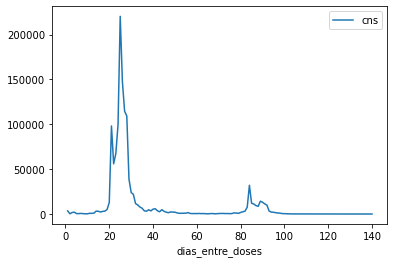

In [10]:
vacinados.loc[(vacinados['data_aplicacao_1a_dose'].notnull()) & (vacinados['data_aplicacao_2a_dose'].notnull()), 'dias_entre_doses'] = (
    vacinados.loc[(vacinados['data_aplicacao_1a_dose'].notnull()) & (vacinados['data_aplicacao_2a_dose'].notnull()), 'data_aplicacao_2a_dose'] -
    vacinados.loc[(vacinados['data_aplicacao_1a_dose'].notnull()) & (vacinados['data_aplicacao_2a_dose'].notnull()), 'data_aplicacao_1a_dose'])

vacinados.loc[vacinados['dias_entre_doses'].notnull(),'dias_entre_doses'] = vacinados.loc[vacinados['dias_entre_doses'].notnull(),'dias_entre_doses'].dt.days
vacinados.loc[(vacinados['dias_entre_doses'].isnull()) | (vacinados['dias_entre_doses'] < 0) ,'dias_entre_doses'] = 0

vacinados.loc[vacinados['dias_entre_doses']!=0,['cns','dias_entre_doses']].groupby('dias_entre_doses').count().plot()

In [11]:
vacinados['situacao'] = 'inconsistencia'
vacinados.loc[(vacinados['data_aplicacao_1a_dose'].notnull()) & (vacinados['data_aplicacao_2a_dose'].isnull()), 'situacao'] = 'só primeira dose'
vacinados.loc[(vacinados['dias_entre_doses']>0), 'situacao'] = 'ambas doses aplicadas'
vacinados[['cns','situacao']].groupby('situacao').count()

,cns
situacao,
ambas doses aplicadas,1297371
inconsistencia,90064
só primeira dose,1811924


<AxesSubplot:xlabel='dias_apos_ultima_dose'>

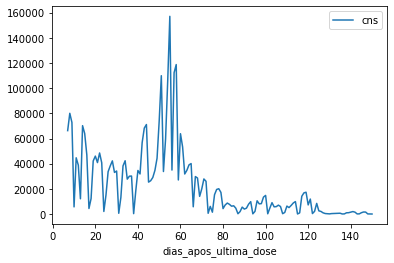

In [12]:
vacinados['data_ultima_dose'] = vacinados['data_aplicacao_1a_dose']
vacinados.loc[vacinados['data_aplicacao_2a_dose'].notna(),'data_ultima_dose'] = vacinados.loc[vacinados['data_aplicacao_2a_dose'].notna(),'data_aplicacao_2a_dose']
vacinados['dias_apos_ultima_dose'] = (vacinados['data_ultima_dose'] - today).dt.days * -1
vacinados[['cns','dias_apos_ultima_dose']].groupby('dias_apos_ultima_dose').count().plot()

<AxesSubplot:xlabel='faixa_etaria'>

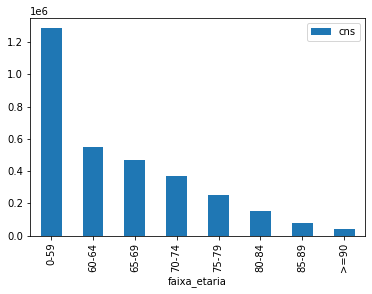

In [13]:
vacinados.loc[(vacinados['data_nascimento'].notnull()) & (vacinados['data_ultima_dose'].notnull()), 'idade'] = \
    vacinados.loc[(vacinados['data_nascimento'].notnull()) & (vacinados['data_ultima_dose'].notnull())].apply(
            lambda row: row['data_ultima_dose'].year - row['data_nascimento'].year - (
                    (row['data_ultima_dose'].month, row['data_ultima_dose'].day) <
                    (row['data_nascimento'].month, row['data_nascimento'].day)
            ), axis=1
    )

vacinados['faixa_etaria'] = [ faixa_etaria_labels[idx] for idx in np.digitize(vacinados['idade'],faixa_etaria,right=False)]
vacinados[['cns','faixa_etaria']].groupby('faixa_etaria').count().plot(kind='bar')

In [14]:
bins = [1,2,3,7,14,21,30,60,90]
bins_label = ['hoje','24 horas','48 horas', '72 horas', '7 dias', '14 dias', '21 dias', '30 dias', '60 dias', '90 dias']
vacinados['periodo_ultima_dose'] = [ x for x in np.digitize(vacinados['dias_apos_ultima_dose'],bins,right=False)]
dias_apos_ultima_dose = vacinados.groupby(['situacao','periodo_ultima_dose'])[['cns']].count().unstack().fillna(0).astype(int).rename(columns={'cns':'qtde'}).droplevel(0,1)
dias_apos_ultima_dose['total'] = dias_apos_ultima_dose.sum(1)
dias_apos_ultima_dose = dias_apos_ultima_dose.append(pd.DataFrame(dias_apos_ultima_dose.sum().tolist(),index=dias_apos_ultima_dose.columns.tolist(),columns=['total']).T)
dias_apos_ultima_dose.columns = [ bins_label[bins] if isinstance(bins,int) else bins for bins in dias_apos_ultima_dose.columns ]
dias_apos_ultima_dose = dias_apos_ultima_dose.reset_index()
dias_apos_ultima_dose.index = [0,2,1,3]
dias_apos_ultima_dose = dias_apos_ultima_dose.sort_index().set_index('index')
dias_apos_ultima_dose.index.name = None
dias_apos_ultima_dose

,7 dias,14 dias,21 dias,30 dias,60 dias,90 dias,total
ambas doses aplicadas,20204,55509,43378,663578,323740,190962,1297371
só primeira dose,299535,229114,249006,768853,208955,56461,1811924
inconsistencia,696,1445,2057,58720,15274,11872,90064
total,320435,286068,294441,1491151,547969,259295,3199359


In [15]:
notifica = Notifica()
notifica.load()
casos_confirmados = notifica.df
casos_confirmados['faixa_etaria'] = [ faixa_etaria_labels[idx] for idx in np.digitize(casos_confirmados['idade'],faixa_etaria,right=False)]
casos_confirmados['ano_caso'] = casos_confirmados['data_diagnostico'].apply(lambda x: x.year if isinstance(x,date) else 'erro')
casos_confirmados['mes_caso'] = casos_confirmados['data_diagnostico'].apply(lambda x: x.month if isinstance(x,date) else 'erro')
casos_confirmados['ano_obito'] = casos_confirmados['data_cura_obito'].apply(lambda x: x.year if isinstance(x,date) else 'erro')
casos_confirmados['mes_obito'] = casos_confirmados['data_cura_obito'].apply(lambda x: x.month if isinstance(x,date) else 'erro')

In [16]:
casos_vacinados_cns = pd.merge(vacinados,casos_confirmados[['cns','id','data_diagnostico','evolucao','data_cura_obito']], on='cns', how='inner')
print(len(casos_vacinados_cns))

casos_vacinados_cpf = pd.merge(vacinados.loc[vacinados['cpf'].notna()],casos_confirmados[['cpf','id','data_diagnostico','evolucao','data_cura_obito']], on='cpf', how='inner')
print(len(casos_vacinados_cpf))

casos_vacinados_mae = pd.merge(vacinados.loc[vacinados['hash_mae'].notna()],casos_confirmados[['hash_mae','id','data_diagnostico','evolucao','data_cura_obito']], on='hash_mae', how='inner')
print(len(casos_vacinados_mae))

casos_vacinados_nasc = pd.merge(vacinados.loc[vacinados['hash_nasc'].notna()],casos_confirmados[['hash_nasc','id','data_diagnostico','evolucao','data_cura_obito']], on='hash_nasc', how='inner')
print(len(casos_vacinados_nasc))

casos_vacinados = pd.concat([casos_vacinados_cns,casos_vacinados_cpf,casos_vacinados_mae,casos_vacinados_nasc])
casos_vacinados = casos_vacinados.drop_duplicates('id', keep='first')
print(len(casos_vacinados))

268582
0
258626
307464
292017


In [17]:
casos_vacinados[['id','evolucao']].groupby('evolucao').count()

,id
evolucao,
1.0,194505
2.0,3956
3.0,64054
4.0,44


In [18]:
casos_vacinados.loc[(casos_vacinados['situacao']=='ambas doses aplicadas') & (casos_vacinados['data_diagnostico'] > casos_vacinados['data_aplicacao_2a_dose']) | (casos_vacinados['dias_apos_ultima_dose'] > 14),'vacinado'] = 2
casos_vacinados.loc[(casos_vacinados['data_diagnostico'] > casos_vacinados['data_aplicacao_1a_dose']) | (casos_vacinados['dias_apos_ultima_dose'] <= 14),'vacinado'] = 1
casos_vacinados.loc[(casos_vacinados['data_diagnostico'] < casos_vacinados['data_aplicacao_1a_dose']) | (casos_vacinados['data_aplicacao_1a_dose'].isna() & (casos_vacinados['data_diagnostico'] < casos_vacinados['data_aplicacao_2a_dose'])),'vacinado'] = 0

casos = pd.merge(casos_confirmados,casos_vacinados[['id','categoria','grupo_atendimento','fabricante','vacina_nome','situacao','vacinado']],how='left',on='id')
casos['vacinado'] = casos['vacinado'].fillna(0)
grupo = casos.groupby(['ano_caso','mes_caso','faixa_etaria','vacinado'])[['id']].count().unstack(-2)
grupo = grupo.droplevel(0,1)
grupo = grupo.fillna(0).astype(int)
grupo

faixa_etaria                  0-59  60-64  65-69  70-74  75-79  80-84  85-89  \
ano_caso mes_caso vacinado                                                     
2020.0   3.0      0.0          303     21      8     10      5      5      2   
         4.0      0.0         1302     63     51     43     33     23     12   
         5.0      0.0         4566    227    168    111     88     58     39   
         6.0      0.0        27817   1315    952    635    412    292    170   
         7.0      0.0        50914   2618   1893   1306    893    559    348   
         8.0      0.0        48249   2574   1830   1258    817    542    331   
         9.0      0.0        39243   2097   1530   1075    658    418    248   
         10.0     0.0        30206   1584   1178    748    516    350    190   
         11.0     0.0        92700   4793   3385   2213   1364    829    419   
         12.0     0.0       107038   6145   4612   3107   2030   1226    681   
2021.0   1.0      0.0        95014   5563   4255   2956   1880   1178    592   
                  1.0          409     15      9      6     10     12     12   
                  2.0            9      0      1      0      0      0      0   
         2.0      0.0        87473   5478   3950   2795   1838   1046    503   
                  1.0         2900     85     43     20     18     21     75   
                  2.0           23      0      0      1      0      0      2   
         3.0      0.0       129330   8054   6029   3910   2130    692    239   
                  1.0         3317    112    105    252    615    908    595   
                  2.0           54      4      9     12     10     14      2   
         4.0      0.0        75240   4310   1512    361    170     86     53   
                  1.0         2453    420   2007   2003   1228    676    320   
                  2.0           41     14     17     12     10      9      4   
         5.0      0.0       147335   1784    616    262    164    118     74   
                  1.0         7416   5923   3730   2253   1480   1006    533   
                  2.0          127     27     26     46     12     19     10   
         6.0      0.0        52955    377    219    103     66     43     21   
                  1.0         6004   2120   1377    879    670    426    239   
                  2.0           35      7     15     11      9      4      7   

faixa_etaria                >=90  
ano_caso mes_caso vacinado        
2020.0   3.0      0.0          1  
         4.0      0.0          5  
         5.0      0.0          9  
         6.0      0.0         94  
         7.0      0.0        216  
         8.0      0.0        200  
         9.0      0.0        150  
         10.0     0.0         97  
         11.0     0.0        237  
         12.0     0.0        335  
2021.0   1.0      0.0        337  
                  1.0         13  
                  2.0          2  
         2.0      0.0        168  
                  1.0        122  
                  2.0          1  
         3.0      0.0         67  
                  1.0        323  
                  2.0          2  
         4.0      0.0         22  
                  1.0        152  
                  2.0          3  
         5.0      0.0         32  
                  1.0        262  
                  2.0          4  
         6.0      0.0          9  
                  1.0         95  
                  2.0          1

In [19]:
obitos_vacinados = casos_vacinados.loc[casos_vacinados['evolucao']==2].copy()
obitos = casos_confirmados.loc[casos_confirmados['evolucao']==2]
obitos = pd.merge(obitos,obitos_vacinados[['id','categoria','grupo_atendimento','fabricante','vacina_nome','situacao','vacinado']],how='left',on='id')
obitos['vacinado'] = obitos['vacinado'].fillna(0)
grupo = casos.groupby(['ano_obito','mes_obito','faixa_etaria','vacinado'])[['id']].count().unstack(-2)
grupo = grupo.droplevel(0,1)
grupo = grupo.fillna(0).astype(int)
grupo

faixa_etaria                   0-59  60-64  65-69  70-74  75-79  80-84  85-89  \
ano_obito mes_obito vacinado                                                    
2020.0    3.0       0.0          48      2      1      1      0      1      0   
          4.0       0.0         370     14     19     12     14     10      6   
          5.0       0.0        1157     69     45     29     21     14     13   
                    1.0           1      0      0      0      0      0      0   
          6.0       0.0        8852    413    291    239    161    114     81   
          7.0       0.0       30101   1486   1082    762    560    362    209   
                    1.0           2      0      0      0      0      0      0   
          8.0       0.0       37756   1990   1454    956    640    441    284   
                    1.0           2      0      0      0      0      0      0   
                    2.0           1      0      0      0      0      0      0   
          9.0       0.0       33426   1788   1300    938    602    390    208   
                    1.0           1      0      0      0      0      0      0   
          10.0      0.0       20724   1179    877    597    400    281    138   
                    1.0           1      0      0      0      0      0      1   
          11.0      0.0       34896   1798   1299    895    605    399    222   
                    1.0           4      0      0      0      0      0      0   
          12.0      0.0       67591   3928   2852   1961   1352    816    438   
                    1.0           4      1      0      0      0      0      0   
2021.0    1.0       0.0       60241   3683   2938   1944   1344    798    455   
                    1.0          72      2      4      2      2      1      0   
                    2.0           2      0      1      0      0      0      0   
          2.0       0.0       47292   2983   2154   1660   1132    649    343   
                    1.0        1228     47     20     10      9      7     18   
                    2.0          10      0      0      0      0      0      1   
          3.0       0.0       81951   5250   4038   2838   1838    852    346   
                    1.0        2098     73     45     48    148    389    330   
                    2.0          38      3      2      1      6     10      2   
          4.0       0.0       64187   4175   2603   1308    683    253     88   
                    1.0        1698    121    682    951    841    598    313   
                    2.0          33      1      6      8      6      7      2   
          5.0       0.0       68646   2092    770    333    188    103     65   
                    1.0        2416   2030   1881   1266    756    508    279   
                    2.0          54     16     16     13      6     11      8   
          6.0       0.0       38902    457    242    116     63     43     28   
                    1.0        2727   1455    935    572    438    291    166   
                    2.0          31      3      5     13      3      4      3   

faixa_etaria                  >=90  
ano_obito mes_obito vacinado        
2020.0    3.0       0.0          0  
          4.0       0.0          6  
          5.0       0.0          4  
                    1.0          0  
          6.0       0.0         44  
          7.0       0.0        128  
                    1.0          0  
          8.0       0.0        163  
                    1.0          0  
                    2.0          0  
          9.0       0.0        147  
                    1.0          0  
          10.0      0.0         86  
                    1.0          0  
          11.0      0.0        117  
                    1.0          0  
          12.0      0.0        226  
                    1.0          0  
2021.0    1.0       0.0        245  
                    1.0          0  
                    2.0          0  
          2.0       0.0        162  
                    1.0         4

In [20]:
# comorbidades = Notifica('comorbidades')
# comorbidades.load()

# fator_risco = comorbidades.schema.loc[comorbidades.schema['group_name']=='comorbidades']
# comorbidades['fator_risco']

# casos_vacinados_comorbidade = pd.merge(casos_vacinados, comorbidades,how='left',on='id')

# #mes - vacinado - for comorbidade em total com comorbidade - com comorbidade - sem comorbidade
# fator_risco = comorbidades.schema.loc[comorbidades.schema['group_name']=='comorbidades']
# grupo = casos.groupby(['ano_obito','mes_obito','vacinado'])[fator_risco['columns'].to_list()].sum()
# grupo = grupo.droplevel(0,1)
# grupo = grupo.fillna(0).astype(int)
# grupo

In [23]:
sivep_confirmados = pd.read_pickle(join(root,'database','sivep','sivep.pkl'))
sivep_confirmados.columns = [ normalize_labels(x) for x in sivep_confirmados.columns ]
sivep_confirmados.columns.values

array(['dt_evoluca', 'dt_encerra', 'observa', 'nome_prof', 'reg_prof',
       'dt_digita', 'histo_vgm', 'pais_vgm', 'co_ps_vgm', 'lo_ps_vgm',
       'dt_vgm', 'dt_rt_vgm', 'pcr_sars2', 'pac_cocbo', 'pac_dscbo',
       'out_anim', 'dor_abd', 'fadiga', 'perd_olft', 'perd_pala',
       'tomo_res', 'tomo_out', 'dt_tomo', 'tp_tes_an', 'dt_res_an',
       'res_an', 'lab_an', 'co_lab_an', 'pos_an_flu', 'tp_flu_an',
       'pos_an_out', 'an_sars2', 'an_vsr', 'an_para1', 'an_para2',
       'an_para3', 'an_adeno', 'an_outro', 'ds_an_out', 'tp_am_sor',
       'sor_out', 'dt_co_sor', 'tp_sor', 'out_sor', 'dt_res', 'res_igg',
       'res_igm', 'res_iga', 'nu_do', 'pov_ct', 'tp_pov_ct', 'tem_cpf',
       'estrang', 'nu_cns', 'vacina_cov', 'dose_1_cov', 'dose_2_cov',
       'lab_pr_cov', 'lote_1_cov', 'lote_2_cov', 'fnt_in_cov',
       'nu_notific', 'dt_notific', 'sem_not', 'dt_sin_pri', 'sem_pri',
       'sg_uf_not', 'id_regiona', 'co_regiona', 'id_municip',
       'co_mun_not', 'id_unidade', 'co_un

<AxesSubplot:xlabel='faixa_etaria'>

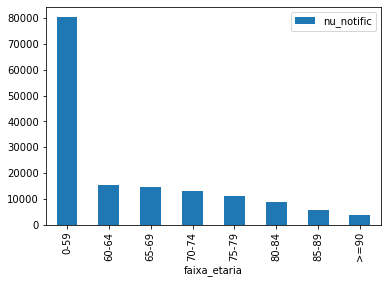

In [24]:
sivep_confirmados.loc[(sivep_confirmados['tp_idade'] == '1') | (sivep_confirmados['tp_idade'] == '2'), 'idade'] = 0
sivep_confirmados['nu_idade_n'] = pd.to_numeric(sivep_confirmados['nu_idade_n'], downcast = 'integer')
sivep_confirmados.loc[sivep_confirmados['tp_idade'] == '3', 'idade'] = sivep_confirmados['nu_idade_n']
sivep_confirmados['faixa_etaria'] = [ faixa_etaria_labels[idx] for idx in np.digitize(sivep_confirmados['idade'],faixa_etaria,right=False)]
sivep_confirmados[['nu_notific','faixa_etaria']].groupby('faixa_etaria').count().plot(kind='bar')

In [31]:
sivep_confirmados['dt_nasc'] = sivep_confirmados['dt_nasc'].apply(lambda x: isvaliddate(pd.to_datetime(x,format='%d/%m/%Y'),date(1900,1,1))) 
sivep_confirmados['dt_pcr'] = sivep_confirmados['dt_pcr'].apply(lambda x: isvaliddate(pd.to_datetime(x,format='%d/%m/%Y'))) 
sivep_confirmados['dt_evoluca'] = sivep_confirmados['dt_evoluca'].apply(lambda x: isvaliddate(pd.to_datetime(x,format='%d/%m/%Y')))

sivep_confirmados['ano_caso'] = sivep_confirmados['dt_pcr'].apply(lambda x: x.year if isinstance(x,date) else 'erro')
sivep_confirmados['mes_caso'] = sivep_confirmados['dt_pcr'].apply(lambda x: x.month if isinstance(x,date) else 'erro')
sivep_confirmados['ano_obito'] = sivep_confirmados['dt_pcr'].apply(lambda x: x.year if isinstance(x,date) else 'erro')
sivep_confirmados['mes_obito'] = sivep_confirmados['dt_evoluca'].apply(lambda x: x.month if isinstance(x,date) else 'erro')

In [ ]:
sivep_confirmados['cns'] = sivep_confirmados['cns'].apply(normalize_cns)
sivep_confirmados['cpf'] = sivep_confirmados['cpf'].apply(normalize_cns)
sivep_confirmados['nm_mae_pac'] = sivep_confirmados['nm_mae_pac'].apply(normalize_campo_aberto)

sivep_confirmados.loc[sivep_confirmados['nm_mae_pac'].notna(),'hash_mae'] = ( sivep_confirmados.loc[sivep_confirmados['nm_mae_pac'].notna(),'nm_paciente'].apply(normalize_hash) +
                                                          sivep_confirmados.loc[sivep_confirmados['nm_mae_pac'].notna(),'nm_mae_pac'].apply(normalize_hash) )

sivep_confirmados.loc[sivep_confirmados['dt_nasc'].notna(),'hash_nasc'] = ( sivep_confirmados.loc[sivep_confirmados['dt_nasc'].notna(),'nm_paciente'].apply(normalize_hash) +
                                                                          sivep_confirmados.loc[sivep_confirmados['dt_nasc'].notna(),'dt_nasc'].apply(date_hash) )

In [ ]:
sivep_vacinados_cns = pd.merge(vacinados,sivep_confirmados[['cns','nu_notific','data_diagnostico','evolucao','data_cura_obito']], on='cns', how='inner')
print(len(sivep_vacinados_cns))

sivep_vacinados_cpf = pd.merge(vacinados.loc[vacinados['cpf'].notna()],sivep_confirmados[['cpf','nu_notific','data_diagnostico','evolucao','data_cura_obito']], on='cpf', how='inner')
print(len(sivep_vacinados_cpf))

sivep_vacinados_mae = pd.merge(vacinados.loc[vacinados['hash_mae'].notna()],sivep_confirmados[['hash_mae','nu_notific','data_diagnostico','evolucao','data_cura_obito']], on='hash_mae', how='inner')
print(len(sivep_vacinados_mae))

sivep_vacinados_nasc = pd.merge(vacinados.loc[vacinados['hash_nasc'].notna()],sivep_confirmados[['hash_nasc','nu_notific','data_diagnostico','evolucao','data_cura_obito']], on='hash_nasc', how='inner')
print(len(sivep_vacinados_nasc))

sivep_vacinados = pd.concat([sivep_vacinados_cns,sivep_vacinados_cpf,sivep_vacinados_mae,sivep_vacinados_nasc])
sivep_vacinados = sivep_vacinados.drop_duplicates('id', keep='first')
print(len(sivep_vacinados))

In [ ]:
sivep_vacinados.loc[(sivep_vacinados['situacao']=='ambas doses aplicadas') & (sivep_vacinados['dt_pcr'] > sivep_vacinados['data_aplicacao_2a_dose']) | (sivep_vacinados['dias_apos_ultima_dose'] > 14),'vacinado'] = 2
sivep_vacinados.loc[(sivep_vacinados['dt_pcr'] > sivep_vacinados['data_aplicacao_1a_dose']) | (sivep_vacinados['dias_apos_ultima_dose'] <= 14),'vacinado'] = 1
sivep_vacinados.loc[(sivep_vacinados['dt_pcr'] < sivep_vacinados['data_aplicacao_1a_dose']) | (sivep_vacinados['data_aplicacao_1a_dose'].isna() & (sivep_vacinados['dt_pcr'] < sivep_vacinados['data_aplicacao_2a_dose'])),'vacinado'] = 0

sivep = pd.merge(sivep,sivep_vacinados[['nu_notific','categoria','grupo_atendimento','fabricante','vacina_nome','situacao','vacinado']],how='left',on='id')
sivep['vacinado'] = sivep['vacinado'].fillna(0)
grupo = sivep.groupby(['ano_caso','mes_caso','faixa_etaria','vacinado'])[['nu_notific']].count().unstack(-2)
grupo = grupo.droplevel(0,1)
grupo = grupo.fillna(0).astype(int)
grupo